In [1]:
# ===================================================================
#   Directional Analysis v2 (ELK + Multi-Loss SSL)
#   Supervised vs. SSL (ELK Backbone) Robustness on Directional Transitional HAR Data
#
#   [수정 사항 요약]
#   1. 백본: ResNet+Transformer -> ELKBackbone (ELK_1003.ipynb 기반)
#   2. 분류기: Linear -> 1D CNN + Linear
#   3. 시나리오: 8개 단방향 -> 12개 양방향
#   4. SSL Loss: 4가지 (InfoNCE, Barlow Twins, Triplet, Cosine) 선택 가능
#   5. 스케줄러: OneCycleLR (Cosine + Warmup) 적용
#   6. 모델: Hyperbolic 제거 (Supervised, SSL 2가지)
#   7. 평가지표: F1-Score (Macro)로 통일
# ===================================================================

In [2]:
import os
import random
import math
import copy
import json
from dataclasses import dataclass, field
from typing import Tuple, Dict, Optional, List

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

In [3]:
# ======================== 1. Random Seed ========================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
# ======================== 2. Configuration (MODIFIED) ========================
@dataclass
class Config:
    """실험 설정을 위한 데이터 클래스"""
    # 경로 설정
    data_dir: str = "C://Users/park9/HAR/data"  # 데이터셋 경로 
    save_dir: str = "C://Users/park9/HAR/03_ELK_Experiment/RESLUTS" # 결과 저장 경로 

    # SSL Pretrain 파라미터
    pretrain_epochs: int = 100
    pretrain_batch_size: int = 512
    pretrain_max_lr: float = 1e-3
    # SSL Loss 선택 ("infonce", "barlow_twins", "triplet", "cosine")
    ssl_loss_type: str = "infonce"
    barlow_lambda: float = 5e-3  # Barlow Twins용 람다
    triplet_margin: float = 1.0  # Triplet Loss용 마진
    temperature: float = 0.07    # InfoNCE용 온도

    # Supervised / Fine-tune 파라미터
    finetune_epochs: int = 50
    finetune_batch_size: int = 128
    finetune_max_lr: float = 3e-4
    finetune_backbone_lr_ratio: float = 0.1 # 백본에 적용할 차등 LR 비율

    # 공통 파라미터
    weight_decay: float = 1e-4
    grad_clip: float = 1.0
    label_smoothing: float = 0.05
    # Cosine + Warmup 스케줄러 (OneCycleLR) 파라미터
    warmup_ratio: float = 0.1 # 10% 웜업

    # ELK 모델 파라미터
    d_model: int = 128
    dropout: float = 0.1
    elk_num_layers: int = 6      # ELK 레이어 수
    elk_kernel_size: int = 31  # ELK 커널 크기
    projection_dim: int = 128    # SSL 프로젝션 헤드 차원

    # Augmentation 파라미터
    aug_max_segments: int = 8
    aug_mask_ratio: float = 0.1
    aug_mag_warp_strength: float = 0.2
    aug_time_warp_strength: float = 0.2
    aug_crop_ratio: float = 0.8

    # 시스템 파라미터
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    num_workers: int = 0 # 0으로 설정 (Jupyter/Colab 환경 호환성)
    
    # 실험 저장용
    all_results: List[dict] = field(default_factory=list)
    
    def __post_init__(self):
        os.makedirs(self.save_dir, exist_ok=True)
        if self.num_workers > 0 and self.device == "cuda":
             print("Warning: num_workers > 0 and CUDA can cause issues in notebooks. Setting num_workers=0.")
             self.num_workers = 0

In [5]:
# ======================== 3. Dataset & Preprocessing ========================
INERTIAL_SIGNALS_FOLDER = "Inertial Signals"
RAW_CHANNELS = [
    ("total_acc_x_", "txt"), ("total_acc_y_", "txt"), ("total_acc_z_", "txt"),
    ("body_acc_x_", "txt"), ("body_acc_y_", "txt"), ("body_acc_z_", "txt"),
    ("body_gyro_x_", "txt"), ("body_gyro_y_", "txt"), ("body_gyro_z_", "txt"),
]
_LABEL_MAP = {1:"WALKING", 2:"WALKING_UPSTAIRS", 3:"WALKING_DOWNSTAIRS", 4:"SITTING", 5:"STANDING", 6:"LAYING"}
_CODE_TO_LABEL_NAME = {i-1: _LABEL_MAP[i] for i in _LABEL_MAP}
LABEL_NAME_TO_CODE = {v: k for k, v in _CODE_TO_LABEL_NAME.items()}

def load_split_raw(root: str, split: str):
    assert split in ("train", "test")

    inertial_path = os.path.join(root, split, INERTIAL_SIGNALS_FOLDER)

    if not os.path.isdir(inertial_path):
        raise FileNotFoundError(f"UCI-HAR 데이터셋 폴더를 찾을 수 없습니다: {inertial_path}")

    X_list = []
    for p, e in RAW_CHANNELS:
        fpath = os.path.join(inertial_path, f"{p}{split}.{e}")
        with open(fpath, "r", encoding="utf-8") as f: arr = np.loadtxt(f)
        X_list.append(arr[..., None])

    X = np.concatenate(X_list, axis=-1).transpose(0, 2, 1) # (N, 9, 128)
    y_path = os.path.join(root, split, f"y_{split}.txt")

    with open(y_path, "r", encoding="utf-8") as f: y = np.loadtxt(f).astype(int) - 1
    print(f"[OK] Loaded {split} data: X{X.shape}, y{y.shape}")

    return X, y

class UCIHARInertial(Dataset):
    def __init__(self, root: str, split: str, mean=None, std=None,
                 preloaded_data: Optional[Tuple[np.ndarray, np.ndarray]] = None):
        super().__init__()

        if preloaded_data is not None:
            X, y = preloaded_data
        else: 
            X, y = load_split_raw(root, split)

        self.X_unnormalized = X.astype(np.float32)
        self.y = y.astype(np.int64)

        if mean is not None and std is not None: self.mean, self.std = mean, std
        else:
            self.mean = self.X_unnormalized.mean(axis=(0, 2), keepdims=True)
            self.std = self.X_unnormalized.std(axis=(0, 2), keepdims=True) + 1e-6

        self.X_normalized = (self.X_unnormalized - self.mean) / self.std

    def __len__(self): return self.X_unnormalized.shape[0]

    def __getitem__(self, idx):
        return (torch.from_numpy(self.X_normalized[idx]), torch.tensor(self.y[idx], dtype=torch.long))

In [6]:
# ======================== 4. Augmentations (ORIGINAL) ========================

# --- 원본 Augmentation 함수들 (축약) ---
def _aug_time_warp(x: torch.Tensor, strength: float) -> torch.Tensor:
    B, C, T = x.shape
    device = x.device

    anchor_points = torch.tensor([0, T/3, 2*T/3, T-1], device=device)

    warp_factors = (torch.rand(B, 1, 4, device=device) * 2 - 1) * strength * (T/3)
    warped_anchors = anchor_points.view(1, 1, 4) + warp_factors

    t_warped = F.interpolate(warped_anchors, size=T, mode='linear', align_corners=True)

    grid_x = (t_warped / (T-1)) * 2 - 1
    grid_y_fixed = torch.zeros(B, 1, T, 1, device=device)

    grid_x_reshaped = grid_x.permute(0, 2, 1).unsqueeze(1)
    grid = torch.cat([grid_x_reshaped, grid_y_fixed], dim=-1)

    warped = F.grid_sample(x.unsqueeze(2), grid, mode='bilinear', padding_mode='reflection', align_corners=True)

    return warped.squeeze(2)

def _aug_magnitude_warp(x: torch.Tensor, strength: float) -> torch.Tensor:
    B, C, T = x.shape
    device = x.device

    anchor_vals = torch.rand(B, C, 4, device=device) * 2 - 1
    warp_factors = anchor_vals * strength + 1.0

    warp_curve = F.interpolate(warp_factors, size=T, mode='linear', align_corners=True)

    return x * warp_curve

def _aug_permutation(x: torch.Tensor, max_segments: int) -> torch.Tensor:
    B, C, T = x.shape

    B, C, T = x.shape
    if T % max_segments != 0:
        # T가 max_segments로 나누어 떨어지지 않으면 패딩 후 자르기
        pad_len = max_segments - (T % max_segments)
        x_padded = F.pad(x, (0, pad_len), mode='reflect')
        T_padded = x_padded.shape[2]
    else:
        x_padded = x
        T_padded = T
        
    seg_len = T_padded // max_segments
    x_split = x_padded.view(B, C, max_segments, seg_len)

    perm = torch.rand(B, max_segments, device=x.device).argsort(dim=1)
    perm = perm.unsqueeze(1).unsqueeze(3).expand(B, C, max_segments, seg_len)
    
    x_permuted = torch.gather(x_split, 2, perm)
    x_permuted = x_permuted.view(B, C, T_padded)

    return x_permuted[:, :, :T]

def _aug_time_masking(x: torch.Tensor, mask_ratio: float) -> torch.Tensor:
    B, C, T = x.shape
    mask_len = int(T * mask_ratio)

    if mask_len == 0: 
        return x

    mask_start = torch.randint(0, T - mask_len + 1, (B, 1, 1), device=x.device)
    indices = torch.arange(T, device=x.device).view(1, 1, T)
    mask = (indices >= mask_start) & (indices < (mask_start + mask_len))

    return x.masked_fill(mask, 0.0)

def _aug_window_crop(x: torch.Tensor, crop_ratio: float) -> torch.Tensor:
    B, C, T = x.shape

    crop_len = int(T * crop_ratio)

    if crop_len == T: 
        return x
    start = torch.randint(0, T - crop_len + 1, (1,)).item()
    x_cropped = x[:, :, start : start + crop_len]

    return F.interpolate(x_cropped, size=T, mode='linear', align_corners=True)

def augment_time_series(x: torch.Tensor, cfg: Config) -> torch.Tensor:
    """ 5가지 증강 기법을 순차적으로 적용"""
    x_aug = x
    x_aug = _aug_time_warp(x_aug, cfg.aug_time_warp_strength)
    x_aug = _aug_magnitude_warp(x_aug, cfg.aug_mag_warp_strength)
    x_aug = _aug_window_crop(x_aug, cfg.aug_crop_ratio)
    x_aug = _aug_permutation(x_aug, cfg.aug_max_segments)
    x_aug = _aug_time_masking(x_aug, cfg.aug_mask_ratio)
    
    return x_aug

In [7]:
# ======================== 5. Model Architectures (MODIFIED) ========================
# ---------------------------
# 5.1) ELK Backbone (ELK_1003.ipynb에서 가져옴)
# ---------------------------
class ELKBlock(nn.Module):
    """ Efficient Large Kernel Block with structural reparameterization. """
    def __init__(self, in_channels, out_channels, kernel_size=31, deploy=False):
        super().__init__()
        self.deploy = deploy
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size

        padding_large1 = kernel_size // 2
        kernel_size_large2 = kernel_size - 2
        padding_large2 = kernel_size_large2 // 2
        kernel_size_small1 = 5
        padding_small1 = kernel_size_small1 // 2
        kernel_size_small2 = 3
        padding_small2 = kernel_size_small2 // 2

        if deploy:
            self.reparam_conv = nn.Conv1d(
                in_channels, in_channels, kernel_size,
                padding=padding_large1, groups=in_channels, bias=True
            )
        else:
            self.dw_large1 = nn.Conv1d(in_channels, in_channels, kernel_size, padding=padding_large1, groups=in_channels, bias=False)
            self.bn_large1 = nn.BatchNorm1d(in_channels)
            self.dw_large2 = nn.Conv1d(in_channels, in_channels, kernel_size_large2, padding=padding_large2, groups=in_channels, bias=False)
            self.bn_large2 = nn.BatchNorm1d(in_channels)
            self.dw_small1 = nn.Conv1d(in_channels, in_channels, kernel_size_small1, padding=padding_small1, groups=in_channels, bias=False)
            self.bn_small1 = nn.BatchNorm1d(in_channels)
            self.dw_small2 = nn.Conv1d(in_channels, in_channels, kernel_size_small2, padding=padding_small2, groups=in_channels, bias=False)
            self.bn_small2 = nn.BatchNorm1d(in_channels)
            self.bn_id = nn.BatchNorm1d(in_channels)

        self.pointwise = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm1d(out_channels),
        )
        self.activation = nn.GELU()

    def forward(self, x):
        if self.deploy:
            x = self.reparam_conv(x)
        else:
            x1 = self.bn_large1(self.dw_large1(x))
            x2 = self.bn_large2(self.dw_large2(x))
            x3 = self.bn_small1(self.dw_small1(x))
            x4 = self.bn_small2(self.dw_small2(x))
            x5 = self.bn_id(x)
            x = x1 + x2 + x3 + x4 + x5
        x = self.activation(x)
        return self.pointwise(x)

    def reparameterize(self):
        if self.deploy: return
        def _fuse(conv, bn):
            if conv is None:
                kernel = torch.zeros((self.in_channels, 1, self.kernel_size), dtype=bn.weight.dtype, device=bn.weight.device)
                center = self.kernel_size // 2
                kernel[:, 0, center] = 1.0
                conv_bias = torch.zeros(self.in_channels, dtype=bn.weight.dtype, device=bn.weight.device)
            else:
                kernel = conv.weight
                conv_bias = torch.zeros(self.in_channels, dtype=bn.weight.dtype, device=bn.weight.device)
            std = (bn.running_var + bn.eps).sqrt()
            gamma = bn.weight
            beta = bn.bias
            running_mean = bn.running_mean
            fused_weight = kernel * (gamma / std).reshape(-1, 1, 1)
            fused_bias = (gamma / std) * (conv_bias - running_mean) + beta
            return fused_weight, fused_bias

        w_l1, b_l1 = _fuse(self.dw_large1, self.bn_large1)
        w_l2, b_l2 = _fuse(self.dw_large2, self.bn_large2)
        w_s1, b_s1 = _fuse(self.dw_small1, self.bn_small1)
        w_s2, b_s2 = _fuse(self.dw_small2, self.bn_small2)
        w_id, b_id = _fuse(None, self.bn_id)

        pad_l2 = (self.kernel_size - self.dw_large2.kernel_size[0]) // 2
        w_l2 = F.pad(w_l2, (pad_l2, pad_l2))
        pad_s1 = (self.kernel_size - self.dw_small1.kernel_size[0]) // 2
        w_s1 = F.pad(w_s1, (pad_s1, pad_s1))
        pad_s2 = (self.kernel_size - self.dw_small2.kernel_size[0]) // 2
        w_s2 = F.pad(w_s2, (pad_s2, pad_s2))

        final_w = w_l1 + w_l2 + w_s1 + w_s2 + w_id
        final_b = b_l1 + b_l2 + b_s1 + b_s2 + b_id

        self.reparam_conv = nn.Conv1d(
            self.in_channels, self.in_channels, self.kernel_size,
            padding=self.kernel_size // 2, groups=self.in_channels, bias=True
        ).to(final_w.device)
        self.reparam_conv.weight.data = final_w
        self.reparam_conv.bias.data = final_b
        self.deploy = True
        for attr in ['dw_large1', 'bn_large1', 'dw_large2', 'bn_large2', 'dw_small1', 'bn_small1', 'dw_small2', 'bn_small2', 'bn_id']:
            if hasattr(self, attr): delattr(self, attr)

class ELKBackbone(nn.Module):
    """ELK Backbone (ELK_1003.ipynb과 동일)"""
    def __init__(self, in_channels=9, d_model=128, num_layers=6, kernel_size=31, dropout=0.1):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv1d(in_channels, d_model, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm1d(d_model),
            nn.GELU(),
        )
        layers = []
        for _ in range(num_layers):
            layers.append(ELKBlock(d_model, d_model, kernel_size=kernel_size))
            layers.append(nn.Dropout(dropout))
        self.elk_layers = nn.Sequential(*layers)
        self.out_channels = d_model

    def forward(self, x):
        x = self.stem(x)
        x = self.elk_layers(x)
        return x # (B, d_model, T)

    def reparameterize(self):
        """추론 모드를 위해 모든 ELKBlock을 재매개변수화합니다."""
        for m in self.modules():
            if isinstance(m, ELKBlock):
                m.reparameterize()

In [8]:
# ---------------------------
# 5.2) 분류기 헤드 (CNN 1층 추가)
# ---------------------------
class ClassificationHead(nn.Module):
    def __init__(self, d_model: int, num_classes: int):
        super().__init__()
        # Classifier에 CNN 한 층 추가
        self.head_conv = nn.Sequential(
            nn.Conv1d(d_model, d_model, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm1d(d_model),
            nn.GELU()
        )
        self.gap = nn.AdaptiveAvgPool1d(1) # Global Average Pooling
        self.fc = nn.Linear(d_model, num_classes)
        
    def forward(self, fmap): # fmap: (B, d_model, T)
        h = self.head_conv(fmap) # (B, d_model, T)
        h = self.gap(h)           # (B, d_model, 1)
        h = h.squeeze(-1)         # (B, d_model)
        return self.fc(h)         # (B, num_classes)

In [9]:
# ---------------------------
# 5.3) SSL 모델 (ELK 백본 사용)
# ---------------------------
class ProjectionHead(nn.Module):
    """ (원본과 동일) """
    def __init__(self, d_model, projection_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, d_model), 
            nn.BatchNorm1d(d_model), 
            nn.ReLU(), 
            nn.Linear(d_model, projection_dim)
        )
    def forward(self, x): return self.net(x)

class SSLModel(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        # 백본을 ELKBackbone으로 교체
        self.backbone = ELKBackbone(
            in_channels=9,
            d_model=cfg.d_model,
            num_layers=cfg.elk_num_layers,
            kernel_size=cfg.elk_kernel_size,
            dropout=cfg.dropout
        )
        self.projection_head = ProjectionHead(cfg.d_model, cfg.projection_dim)
        self.gap = nn.AdaptiveAvgPool1d(1)

    def forward(self, x):
        fmap = self.backbone(x) # (B, d_model, T)
        pooled = self.gap(fmap).squeeze(-1) # (B, d_model)
        return self.projection_head(pooled) # (B, projection_dim)
    
    def reparameterize(self):
        """추론 모드를 위해 백본의 ELK 블록을 재매개변수화합니다."""
        for m in self.modules():
            if isinstance(m, ELKBlock):
                m.reparameterize()

In [10]:
# ======================== 6. SSL Contrastive Losses ========================
# ---------------------------
# 6.1) InfoNCE Loss (SimCLR style, 원본과 동일)
# ---------------------------
def infonce_loss(z1, z2, temp):
    z1 = F.normalize(z1, dim=-1)
    z2 = F.normalize(z2, dim=-1)
    z = torch.cat([z1, z2], dim=0)
    sim = z @ z.t()
    sim = sim - sim.max(dim=1, keepdim=True).values # 안정화
    B = z1.size(0)
    labels = torch.cat([torch.arange(B) + B, torch.arange(B)], 0).to(z.device)
    mask = torch.eye(2 * B, device=z.device, dtype=torch.bool)
    sim = sim.masked_fill(mask, -float('inf'))
    return F.cross_entropy(sim / temp, labels)

# ---------------------------
# 6.2) Barlow Twins Loss (NEW)
# ---------------------------
def barlow_twins_loss(z1, z2, lambda_param, eps=1e-8):
    B, D = z1.shape
    
    # 1. Batch-wise normalization
    z1_norm = (z1 - z1.mean(0)) / (z1.std(0) + eps)
    z2_norm = (z2 - z2.mean(0)) / (z2.std(0) + eps)
    
    # 2. Cross-correlation matrix
    C = (z1_norm.T @ z2_norm) / B # (D, D)
    
    # 3. Loss calculation
    on_diag = torch.diagonal(C).add_(-1).pow_(2).sum()
    off_diag = C.clone().fill_diagonal_(0).pow_(2).sum()
    
    loss = on_diag + lambda_param * off_diag
    return loss

# ---------------------------
# 6.3) Triplet Loss (NEW)
# ---------------------------
def triplet_loss(z1, z2, margin):
    # z1: anchor, z2: positive
    # z2.roll(1)을 negative로 사용 (간단한 hard negative mining)
    z1 = F.normalize(z1, dim=-1)
    z2 = F.normalize(z2, dim=-1)
    negative = z2.roll(shifts=1, dims=0)
    
    return F.triplet_margin_loss(z1, z2, negative, margin=margin, p=2)

# ---------------------------
# 6.4) Cosine Similarity Loss (NEW)
# ---------------------------
def cosine_similarity_loss(z1, z2):
    # (1 - cos_sim) / 2
    z1 = F.normalize(z1, dim=-1)
    z2 = F.normalize(z2, dim=-1)
    loss = - F.cosine_similarity(z1, z2).mean()
    return loss

In [11]:
# ======================== 7. Training & Evaluation Logic ========================

def pretrain_one_epoch(model, loader, opt, scheduler, cfg):
    model.train(); total_loss, n = 0.0, 0
    for x, _ in loader:
        x1, x2 = augment_time_series(x.to(cfg.device), cfg), augment_time_series(x.to(cfg.device), cfg)
        
        opt.zero_grad(set_to_none=True)
        z1, z2 = model(x1), model(x2)
        
        # 4가지 Loss 분기 처리
        if cfg.ssl_loss_type == 'infonce':
            loss = infonce_loss(z1, z2, cfg.temperature)
        elif cfg.ssl_loss_type == 'barlow_twins':
            loss = barlow_twins_loss(z1, z2, cfg.barlow_lambda)
        elif cfg.ssl_loss_type == 'triplet':
            loss = triplet_loss(z1, z2, cfg.triplet_margin)
        elif cfg.ssl_loss_type == 'cosine':
            loss = cosine_similarity_loss(z1, z2)
        else:
            raise ValueError(f"Unknown SSL loss type: {cfg.ssl_loss_type}")
            
        if torch.isnan(loss): continue
            
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip)
        opt.step()
        # 스케줄러를 배치마다 업데이트 (OneCycleLR)
        if scheduler: scheduler.step()
            
        total_loss += loss.item() * x.size(0); n += x.size(0)
    return {"ssl_loss": total_loss / n if n > 0 else 0}

def train_downstream_epoch(backbone, head, loader, opt, scheduler, cfg):
    backbone.train(); head.train(); total_loss, total_corr, n = 0.0, 0, 0
    all_params = list(backbone.parameters()) + list(head.parameters())
    
    for x, y in loader:
        x, y = x.to(cfg.device), y.to(cfg.device)
        opt.zero_grad(set_to_none=True)
        
        logits = head(backbone(x))
        # Supervised / Finetune은 CE Loss 사용 (요청사항 5)
        loss = F.cross_entropy(logits, y, label_smoothing=cfg.label_smoothing)
        
        loss.backward()
        nn.utils.clip_grad_norm_(all_params, cfg.grad_clip)
        opt.step()
        # 스케줄러를 배치마다 업데이트 (OneCycleLR)
        if scheduler: scheduler.step()
            
        total_loss += loss.item() * y.size(0)
        total_corr += (logits.argmax(dim=-1) == y).sum().item()
        n += y.size(0)
        
    return {"loss": total_loss / n if n > 0 else 0, "acc_fake": total_corr / n if n > 0 else 0} # acc는 사용 안함

@torch.no_grad()
def evaluate_model(backbone, head, loader, cfg):
    backbone.eval(); head.eval(); y_true, y_pred = [], []
    for x, y in loader:
        logits = head(backbone(x.to(cfg.device)))
        y_pred.append(logits.argmax(dim=-1).cpu().numpy())
        y_true.append(y.numpy())
    y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)
    
    # F1-score만 측정
    f1 = f1_score(y_true, y_pred, average='macro')
    
    # 디버깅/리포트용
    report = classification_report(y_true, y_pred, target_names=_CODE_TO_LABEL_NAME.values(), digits=4)
    cm = confusion_matrix(y_true, y_pred)
    
    return f1, report, cm

In [12]:
# ======================== 8. Directional Test Set Creation ========================
def create_directional_test_set(
    orig_dataset: UCIHARInertial,
    source_class: str,
    target_class: str,
    p: float,
    mix: float) -> Tuple[UCIHARInertial, dict]:
    """
    지정된 단일 방향(source_class -> target_class)으로만 전이 데이터를 생성합니다.
    """
    X_orig, y_orig = orig_dataset.X_unnormalized, orig_dataset.y
    X_mod, y_mod = X_orig.copy(), y_orig.copy()
    N, C, T = X_mod.shape

    code_source = LABEL_NAME_TO_CODE[source_class]
    code_target = LABEL_NAME_TO_CODE[target_class]
    
    idx_source = np.where(y_mod == code_source)[0]
    idx_target = np.where(y_mod == code_target)[0]
    
    if len(idx_source) == 0 or len(idx_target) == 0:
        print(f"Warning: No samples found for {source_class} or {target_class}. Skipping...")
        return None, None
        
    mix_pts = int(T * mix)

    # Source -> Target 전이 생성 (Source 샘플의 뒷부분을 Target의 앞부분으로 교체)
    num_to_modify = int(len(idx_source) * p)
    if num_to_modify == 0: num_to_modify = 1 # 최소 1개는 변경
        
    targets_to_modify = np.random.choice(idx_source, num_to_modify, replace=False)
    source_pool_for_stitch = np.random.choice(idx_target, num_to_modify, replace=True)
    
    for target_idx, source_idx in zip(targets_to_modify, source_pool_for_stitch):
        X_mod[target_idx, :, -mix_pts:] = X_orig[source_idx, :, :mix_pts]
        
    mod_dataset = UCIHARInertial(
        root="", split="test", mean=orig_dataset.mean, std=orig_dataset.std,
        preloaded_data=(X_mod, y_mod)
    )
    info = {
        'source_class': source_class, 'target_class': target_class, 'p': p, 'mix': mix,
        'scenario_key': f"{source_class}_to_{target_class}"
    }
    return mod_dataset, info

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer): return int(obj)
        if isinstance(obj, np.floating): return float(obj)
        if isinstance(obj, np.ndarray): return obj.tolist()
        return super(NumpyEncoder, self).default(obj)

In [ ]:
# ======================== 9. Main Experiment Runner ========================
# (실험 1회(SL 1회 또는 SSL 1회)를 실행하는 함수로 리팩토링)

def run_one_experiment(cfg: Config, experiment_name: str, method: str,
                       train_set: UCIHARInertial, test_set_orig: UCIHARInertial,
                       transition_test_data: list):
    
    print(f"\n{'='*10} Starting Experiment: {experiment_name} {'='*10}")
    random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

    finetune_loader = DataLoader(train_set, cfg.finetune_batch_size, shuffle=True, num_workers=cfg.num_workers)
    test_loader_orig = DataLoader(test_set_orig, cfg.finetune_batch_size, num_workers=cfg.num_workers)

    # --- Model Training ---
    if method == 'supervised':
        # ELK 백본 + 신규 CNN 헤드
        backbone = ELKBackbone(in_channels=9, d_model=cfg.d_model, num_layers=cfg.elk_num_layers, kernel_size=cfg.elk_kernel_size, dropout=cfg.dropout).to(cfg.device)
        head = ClassificationHead(cfg.d_model, 6).to(cfg.device)
        
        # Cosine + Warmup (OneCycleLR) 스케줄러 적용
        params = list(backbone.parameters()) + list(head.parameters())
        opt = torch.optim.AdamW(params, lr=cfg.finetune_max_lr, weight_decay=cfg.weight_decay)
        total_steps = cfg.finetune_epochs * len(finetune_loader)
        scheduler = OneCycleLR(opt, max_lr=cfg.finetune_max_lr, total_steps=total_steps, pct_start=cfg.warmup_ratio)
        
        train_fn = train_downstream_epoch
        train_epochs = cfg.finetune_epochs
        
    else: # 'ssl'
        print(" --- Stage 1: Self-Supervised Pretraining ---")
        ssl_model = SSLModel(cfg).to(cfg.device)
        pretrain_loader = DataLoader(train_set, cfg.pretrain_batch_size, shuffle=True, num_workers=cfg.num_workers)
        
        ssl_opt = torch.optim.AdamW(ssl_model.parameters(), lr=cfg.pretrain_max_lr, weight_decay=cfg.weight_decay)
        # Pretrain 스케줄러
        total_steps_pre = cfg.pretrain_epochs * len(pretrain_loader)
        pre_scheduler = OneCycleLR(ssl_opt, max_lr=cfg.pretrain_max_lr, total_steps=total_steps_pre, pct_start=cfg.warmup_ratio)
        
        for epoch in range(1, cfg.pretrain_epochs + 1):
            stats = pretrain_one_epoch(ssl_model, pretrain_loader, ssl_opt, pre_scheduler, cfg)
            if epoch % (cfg.pretrain_epochs // 5) == 0 or epoch == 1:
                print(f"  [Pretrain Epoch {epoch:03d}] SSL Loss ({cfg.ssl_loss_type}): {stats['ssl_loss']:.4f}")
        
        print(" --- Stage 2: Fine-tuning ---")
        backbone = ssl_model.backbone # Pretrain된 ELK 백본
        head = ClassificationHead(cfg.d_model, 6).to(cfg.device)
        
        # Finetune 옵티마이저 (백본은 더 작은 LR 적용 - Unfreeze)
        # (ELKBlock의 BatchNorm 레이어도 backbone.parameters()에 포함되어 unfreeze됨)
        opt = torch.optim.AdamW([
            {'params': backbone.parameters(), 'lr': cfg.finetune_max_lr * cfg.finetune_backbone_lr_ratio},
            {'params': head.parameters(), 'lr': cfg.finetune_max_lr}], 
            weight_decay=cfg.weight_decay
        )
        # Finetune 스케줄러
        total_steps_ft = cfg.finetune_epochs * len(finetune_loader)
        scheduler = OneCycleLR(opt, max_lr=[cfg.finetune_max_lr * cfg.finetune_backbone_lr_ratio, cfg.finetune_max_lr], 
                             total_steps=total_steps_ft, pct_start=cfg.warmup_ratio)
        
        train_fn = train_downstream_epoch
        train_epochs = cfg.finetune_epochs

    # --- 공통 훈련 루프 (SL 또는 SSL-Finetune) ---
    best_f1, best_wts = 0.0, None
    for epoch in range(1, train_epochs + 1):
        stats = train_fn(backbone, head, finetune_loader, opt, scheduler, cfg)
        
        # F1-Score로 평가
        val_f1, _, _ = evaluate_model(backbone, head, test_loader_orig, cfg)
        
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_wts = {'backbone': copy.deepcopy(backbone.state_dict()), 'head': copy.deepcopy(head.state_dict())}
            
        if epoch % (train_epochs // 5) == 0 or epoch == 1:
            print(f"  [Downstream Epoch {epoch:02d}] Train Loss: {stats['loss']:.4f} | Test F1: {val_f1:.4f} (Best {best_f1:.4f})")
    
    print(f" Best Test F1-Score: {best_f1:.4f}")
    backbone.load_state_dict(best_wts['backbone'])
    head.load_state_dict(best_wts['head'])
    
    # ELK 모델은 추론 전 재매개변수화 (reparameterize) 수행
    if method == 'ssl':
        # SSLModel은 backbone을 내부에 갖고 있으므로, backbone만 꺼내서 reparam
        backbone.reparameterize()
    else: # Supervised는 backbone 자체가 모델
        backbone.reparameterize()

    # --- Evaluation ---
    # F1-Score만 사용
    f1_orig, report_orig, cm_orig = evaluate_model(backbone, head, test_loader_orig, cfg)
    print(f"\n Final Original Test Performance: F1-Macro={f1_orig:.4f}")
    print("Original Report:\n", report_orig)
    
    transition_results_detailed = {}
    print(" Evaluating on directional transitional test sets...")
    for test_set_mod, info in transition_test_data:
        test_loader_mod = DataLoader(test_set_mod, cfg.finetune_batch_size, num_workers=cfg.num_workers)
        
        # F1-Score만 사용
        f1_trans, _, _ = evaluate_model(backbone, head, test_loader_mod, cfg)
        
        scenario_key = info['scenario_key']
        if scenario_key not in transition_results_detailed: 
            transition_results_detailed[scenario_key] = []
        
        transition_results_detailed[scenario_key].append({"mix_ratio": info['mix'], "f1": f1_trans})
    
    # 이 실험의 결과를 딕셔너리로 반환
    return {
        "config": experiment_name, 
        "orig_f1": f1_orig,
        "transition_results": transition_results_detailed,
        "original_report": report_orig,
        "original_cm": cm_orig
    }

In [14]:
# ======================== 10. Analysis & Visualization ========================
# F1-Score 전용
def analyze_and_visualize_results(results_path: str, save_dir: str):
    try:
        with open(results_path, 'r') as f: results_data = json.load(f)
    except FileNotFoundError:
        print(f"🚨 Error: Results file not found at {results_path}"); return

    print("\n" + "="*10 + "\n Experiment Analysis & Visualization (F1-Score)\n" + "="*10)
    records = []
    for result in results_data:
        for scenario, values in result['transition_results'].items():
            for value in values:
                records.append({
                    'Model': result['config'], 
                    'Scenario': scenario.replace('_', ' '),
                    'Mix Ratio': value['mix_ratio'], 
                    'F1-Score': value['f1'] # F1-Score 사용
                })
    df = pd.DataFrame(records)
    if df.empty: print("No data to visualize."); return

    # Metric을 'F1-Score'로 고정
    metric = 'F1-Score'
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # 시나리오가 12개로 늘어났으므로 col_wrap=4로 3줄 표시
    num_scenarios = len(df['Scenario'].unique())
    col_wrap = 4
    
    g = sns.FacetGrid(df, col="Scenario", col_wrap=col_wrap, hue="Model", height=3.5, aspect=1.2,
                      col_order=sorted(df['Scenario'].unique()),
                      palette='viridis', margin_titles=True)
    g.map(sns.lineplot, "Mix Ratio", metric, marker='o', linewidth=2).add_legend(title="Model")
    g.fig.suptitle(f'Directional Robustness Analysis ({metric})', fontsize=20, y=1.03)
    g.set_axis_labels("Interference Strength (Mix Ratio)", metric, fontsize=12)
    g.set_titles(col_template="{col_name}", size=11)
    g.set(ylim=(min(df[metric]) - 0.05, 1.0))
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    fig_path = os.path.join(save_dir, f"03_directional_robustness_{metric}.png")
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"  - Saved visualization for {metric} to {fig_path}")
    plt.show()
    
    # F1-Score 평균 계산
    print("\n--- Average F1-Score (All Scenarios) ---")
    avg_f1 = df.groupby(['Model', 'Mix Ratio'])['F1-Score'].mean().reset_index()
    
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=avg_f1, x='Mix Ratio', y='F1-Score', hue='Model', marker='o', palette='viridis', linewidth=2.5)
    plt.title('Average F1-Score vs. Interference Strength', fontsize=16)
    plt.xlabel('Interference Strength (Mix Ratio)', fontsize=12)
    plt.ylabel('Average F1-Score (Macro)', fontsize=12)
    plt.legend(title='Model')
    plt.ylim(min(avg_f1['F1-Score']) - 0.05, 1.0)
    plt.grid(True, linestyle='--')
    
    avg_fig_path = os.path.join(save_dir, f"03_average_robustness_{metric}.png")
    plt.savefig(avg_fig_path, dpi=300, bbox_inches='tight')
    print(f"  - Saved average F1 visualization to {avg_fig_path}")
    plt.show()

 🔬 Directional Main Experiment v2 (ELK + Multi-SSL)
  - Device: cuda
  - Backbone: ELKBackbone (Layers=6, K=31)
  - Classifier: 1D-Conv + Linear
  - Scheduler: OneCycleLR (Warmup=10.0%)
  - Results will be saved in: C://Users/park9/HAR/03_ELK_Experiment/RESLUTS

Loading UCI-HAR Dataset...
[OK] Loaded train data: X(7352, 9, 128), y(7352,)
[OK] Loaded test data: X(2947, 9, 128), y(2947,)

Creating 12 Bi-directional Transitional Test Sets (Total: 60)...
  - Created 60 test sets.

========== Starting Experiment: Supervised ==========
  [Downstream Epoch 01] Train Loss: 1.5891 | Test F1: 0.3504 (Best 0.3504)
  [Downstream Epoch 10] Train Loss: 0.3309 | Test F1: 0.9383 (Best 0.9456)
  [Downstream Epoch 20] Train Loss: 0.3123 | Test F1: 0.9418 (Best 0.9456)
  [Downstream Epoch 30] Train Loss: 0.2991 | Test F1: 0.9407 (Best 0.9456)
  [Downstream Epoch 40] Train Loss: 0.2910 | Test F1: 0.9400 (Best 0.9456)
  [Downstream Epoch 50] Train Loss: 0.2929 | Test F1: 0.9371 (Best 0.9456)
 Best Test F1-

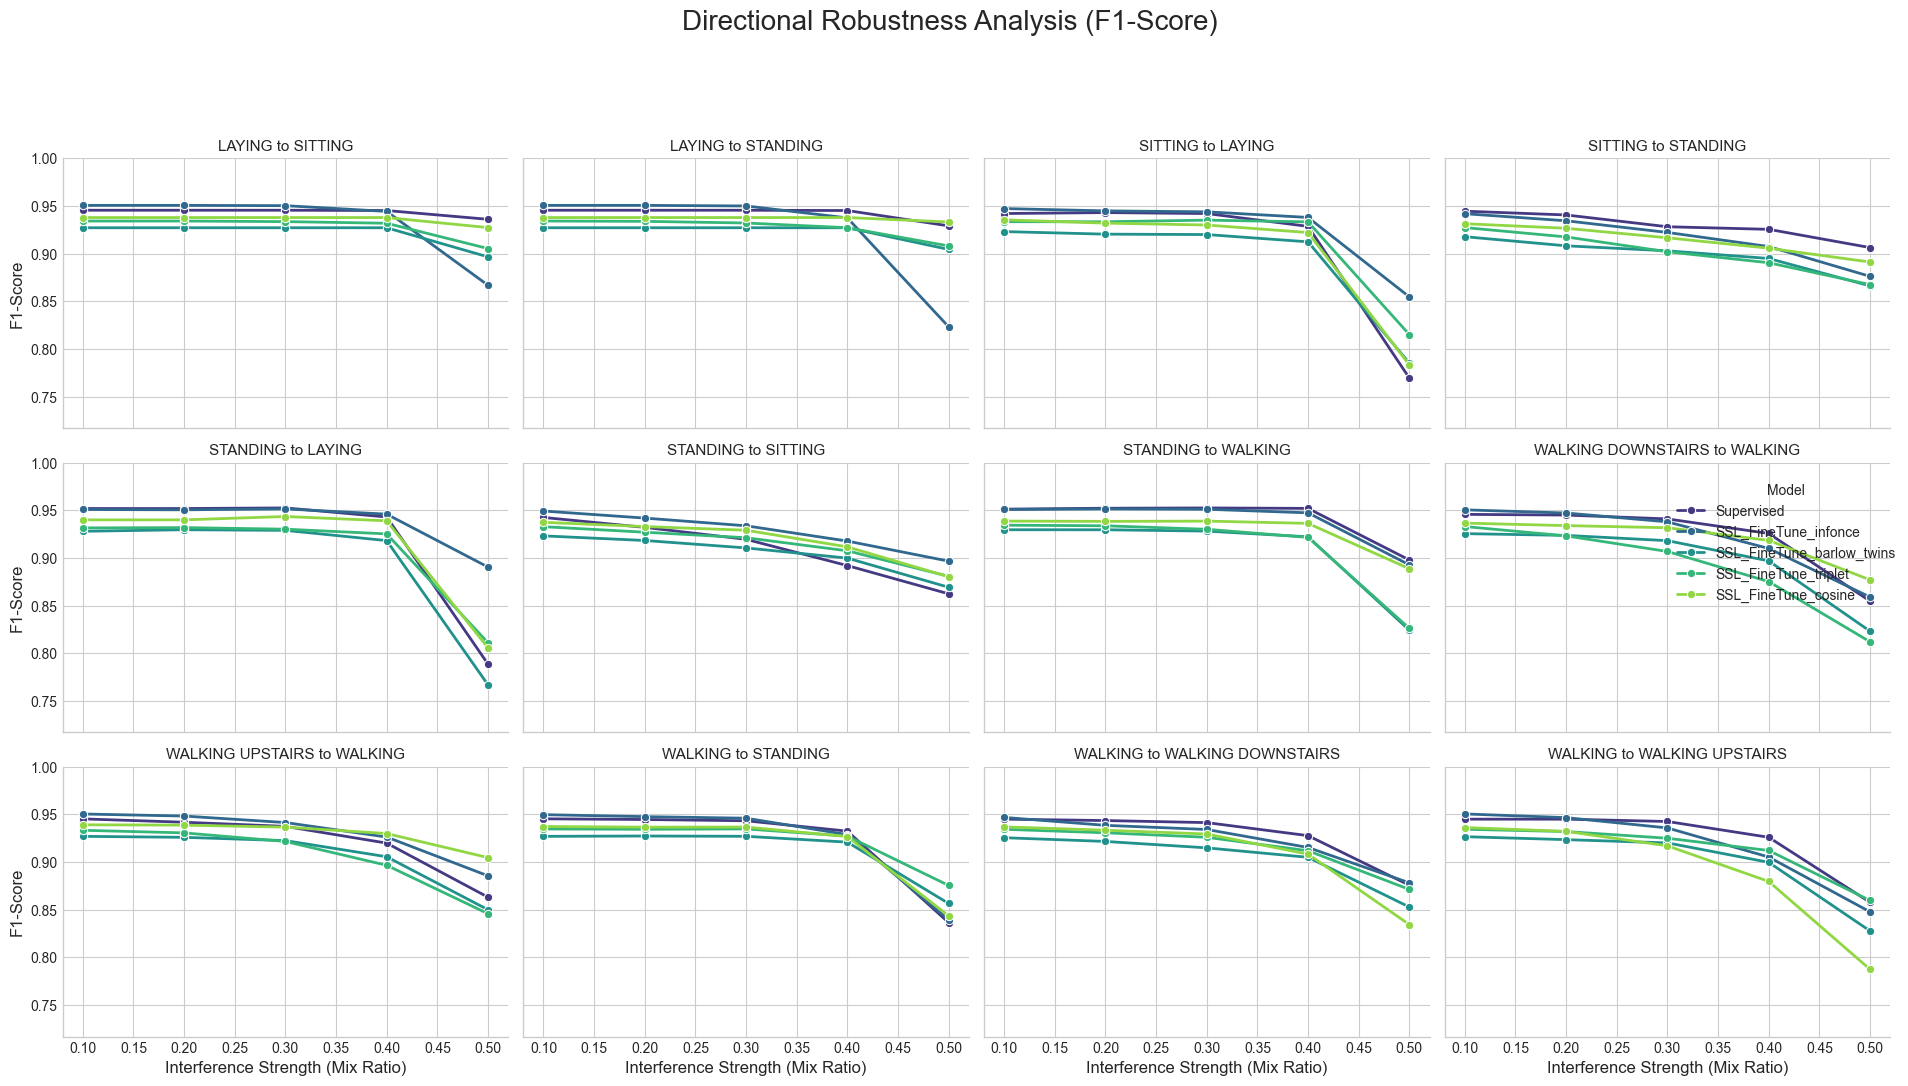


--- Average F1-Score (All Scenarios) ---
  - Saved average F1 visualization to C://Users/park9/HAR/03_ELK_Experiment/RESLUTS\03_average_robustness_F1-Score.png


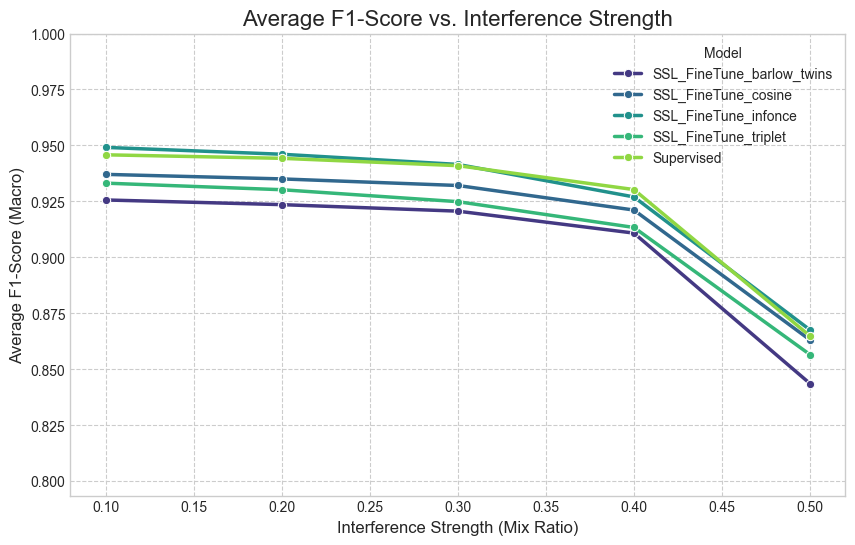

In [15]:
# ======================== 11. Main Entry Point (MODIFIED) ========================
def main():
    cfg = Config()
    
    print("="*80)
    print(" 🔬 Directional Main Experiment v2 (ELK + Multi-SSL)")
    print("="*80)
    print(f"  - Device: {cfg.device}")
    print(f"  - Backbone: ELKBackbone (Layers={cfg.elk_num_layers}, K={cfg.elk_kernel_size})")
    print(f"  - Classifier: 1D-Conv + Linear")
    print(f"  - Scheduler: OneCycleLR (Warmup={cfg.warmup_ratio*100}%)")
    print(f"  - Results will be saved in: {cfg.save_dir}")
    print("="*80 + "\n")
    
    # --- 1. 데이터 로드 ---
    print("Loading UCI-HAR Dataset...")
    train_set = UCIHARInertial(cfg.data_dir, "train")
    test_set_orig = UCIHARInertial(cfg.data_dir, "test", mean=train_set.mean, std=train_set.std)

    # --- 2. 양방향 시나리오 12개 생성 ---
    directional_scenarios = [
        # SITTING, STANDING, LAYING (6)
        ("SITTING", "STANDING"), ("STANDING", "SITTING"),
        ("SITTING", "LAYING"), ("LAYING", "SITTING"),
        ("STANDING", "LAYING"), ("LAYING", "STANDING"),
        # STANDING, WALKING (2)
        ("STANDING", "WALKING"), ("WALKING", "STANDING"),
        # WALKING, WALKING_DOWNSTAIRS/UPSTAIRS (4)
        ("WALKING", "WALKING_DOWNSTAIRS"), ("WALKING_DOWNSTAIRS", "WALKING"),
        ("WALKING", "WALKING_UPSTAIRS"), ("WALKING_UPSTAIRS", "WALKING"),
    ]
    mix_ratios = [0.1, 0.2, 0.3, 0.4, 0.5] 

    print(f"\nCreating {len(directional_scenarios)} Bi-directional Transitional Test Sets (Total: {len(directional_scenarios) * len(mix_ratios)})...")
    transition_test_data = []
    for source_cls, target_cls in directional_scenarios:
        for mix_ratio in mix_ratios:
            test_set_mod, info = create_directional_test_set(test_set_orig, source_cls, target_cls, p=1.0, mix=mix_ratio)
            if test_set_mod is not None:
                transition_test_data.append((test_set_mod, info))
    print(f"  - Created {len(transition_test_data)} test sets.")

    all_results = []
    
    # --- 3. 실험 1: Supervised ---
    cfg_sl = copy.deepcopy(cfg)
    sl_results = run_one_experiment(
        cfg=cfg_sl,
        experiment_name="Supervised",
        method="supervised",
        train_set=train_set,
        test_set_orig=test_set_orig,
        transition_test_data=transition_test_data
    )
    all_results.append(sl_results)

    # --- 4. 실험 2~5: SSL (4가지 Loss) ---
    ssl_loss_types = ["infonce", "barlow_twins", "triplet", "cosine"]
    for loss_type in ssl_loss_types:
        cfg_ssl = copy.deepcopy(cfg)
        cfg_ssl.ssl_loss_type = loss_type
        
        ssl_results = run_one_experiment(
            cfg=cfg_ssl,
            experiment_name=f"SSL_FineTune_{loss_type}",
            method="ssl",
            train_set=train_set,
            test_set_orig=test_set_orig,
            transition_test_data=transition_test_data
        )
        all_results.append(ssl_results)

    # --- 5. 결과 저장 ---
    save_path = os.path.join(cfg.save_dir, "03_ELK_Experiment.json")
    with open(save_path, "w") as f: json.dump(all_results, f, indent=2, cls=NumpyEncoder)
    print(f"\nAll experiment results saved to: {save_path}")
    
    # --- 6. 시각화 (F1-Score 기준) ---
    analyze_and_visualize_results(save_path, cfg.save_dir)

if __name__ == "__main__":
    main()

## 실험 결과 요약

#### 1. 원본 데이터 성능
- **`Supervised`: 0.9456**
- `SSL_FineTune_infonce`: 0.9350
- `SSL_FineTune_barlow_twins`: 0.9369
- `SSL_FineTune_triplet`: 0.9317
- `SSL_FineTune_cosine`: 0.9369

SSL 모델 중엔 `Barlow Twins`와 `Cosine Loss`가 가장 근접

#### 2. 전이 데이터 성능 (평균 F1-score)
*60종의 모든 전이 시나리오(12개 * 5개 mix_rate)에 대한 F1-score의 평균값으로 비교*

- `Supervised`: 0.8655
- `SSL_FineTune_infonce`: 0.8718
- **`SSL_FineTune_barlow_twins`: 0.8752**
- `SSL_FineTune_triplet`: 0.8647
- **`SSL_FineTune_cosine`: 0.8753**

SSL 모델들 (특히 `Barlow Twins`와 `Cosine Loss`)이 Supervised보다 우수\
`Triplet Loss`는 Supervised 모델과 비슷한 성능 

#### 3. 결론
- 원본 데이터 성능: `Supervised`
- 전이 데이터 성능: `SSL_FineTune_BarlowTwins` $ `SSL_FineTune_Cosine`